In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
import os
from pandas.plotting import scatter_matrix
from seaborn import heatmap
from sklearn import datasets, linear_model
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn import preprocessing
%matplotlib inline

### Zillow is predicting their own home value index. In order to extrapolate conclusions from the much longer time series of real estate indices at national and major metro areas, it is important to calibrate the ZHVI metro area indices to those of Case-Schiller. Note that the ZHVI Index methodology removes foreclosures from their estimates so their data should be inherently upward-biased relative to the Case-Schiller data. In order to calibrate both models, for each of the metro areas in Case-Schiller, divide its Case-Schiller index by the corresponding ZHVI index. Normalize both indices to be 1 on the first available data for ZHVI. The resulting multiplicative factors will allow you to translate statements about ZHVI to statements about Case-Schiller. In particular, you will be able to use results from your national macro and statewide Case-Schiller models to draw conclusions about ZHVI.

In [84]:
states_ls = ['Arizona', 'California','Colorado', 'District of Columbia','Florida','Georgia','Illinois','Massachusetts','Michigan','Minnesota','Nevada','New York','North Carolina','Ohio','Oregon','Texas','Washington']
states_abbrev = ['AZ', 'CA', 'CO', 'DC', 'FL', 'GA', 'IL', 'MA', 'MI', 'MN', 'NV', 'NY', 'NC', 'OH', 'OR', 'TX', 'WA']
metro_ls = []
for string in Case_Shiller.columns:
    metro_ls.append(string.split('_')[0])
metro_ls

['Atlanta',
 'Boston',
 'Charlotte',
 'Chicago',
 'Cleveland',
 'Dallas',
 'Denver',
 'Detroit',
 'Las Vegas',
 'Los Angelos',
 'Miami',
 'Minneapolis',
 'New York',
 'Phoenix',
 'Portland',
 'San Diego',
 'San Francisco',
 'Seattle',
 'Tampa',
 'Washington']

In [112]:
ZHVI = pd.read_csv('Metro_Zhvi_AllHomes.csv', encoding = 'unicode_escape')
cols = ['RegionID', 'RegionName', 'SizeRank']
ZHVI = ZHVI.set_index(cols).T
ZHVI.index = pd.to_datetime(ZHVI.index)
ZHVI.columns = ZHVI.columns.droplevel(['RegionID', 'SizeRank'])
ZHVI.index.name = 'Date'
idx = []
for i in range(len(ZHVI.columns)):
    if ZHVI.columns[i].split(',')[0] in metro_ls:
        idx.append(ZHVI.columns[i])
idx.append("Dallas-Fort Worth, TX")
idx.append('Minneapolis-St Paul, MN')
idx.append('Los Angeles-Long Beach-Anaheim, CA')
idx.append('Miami-Fort Lauderdale, FL')
ZHVI = ZHVI[idx]
ZHVI = ZHVI.reindex_axis(sorted(ZHVI.columns), axis=1)
ZHVI = ZHVI.drop(columns = ['Cleveland, TN', 'Portland, ME', 'Miami, OK'], axis = 1)
ZHVI.head()

/Users/Violet/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  app.launch_new_instance()


RegionName,"Atlanta, GA","Boston, MA","Charlotte, NC","Chicago, IL","Cleveland, OH","Dallas-Fort Worth, TX","Denver, CO","Detroit, MI","Las Vegas, NV","Los Angeles-Long Beach-Anaheim, CA","Miami-Fort Lauderdale, FL","Minneapolis-St Paul, MN","New York, NY","Phoenix, AZ","Portland, OR","San Diego, CA","San Francisco, CA","Seattle, WA","Tampa, FL","Washington, DC"
Date,,,,,,,,,,,,,,,,,,,,
1996-04-01,102500.0,150100.0,95800.0,138300.0,102300.0,115300.0,133900.0,93900.0,128000.0,170600.0,95000.0,106000.0,165000.0,104800.0,NaN,163600.0,228400.0,155700.0,75400.0,155800.0
1996-05-01,103100.0,150600.0,96900.0,138900.0,102500.0,115400.0,134000.0,94500.0,127900.0,170400.0,95100.0,106200.0,164800.0,105400.0,NaN,163200.0,228200.0,155400.0,75100.0,155500.0
1996-06-01,103900.0,151200.0,97900.0,139300.0,102800.0,115500.0,134100.0,95200.0,127700.0,170100.0,95100.0,106600.0,164600.0,106100.0,NaN,162800.0,228100.0,155300.0,74800.0,155300.0
1996-07-01,104700.0,151800.0,98900.0,139400.0,103200.0,115700.0,134200.0,95800.0,127500.0,169800.0,95100.0,107100.0,164300.0,106700.0,NaN,162400.0,228100.0,155300.0,74600.0,155000.0
1996-08-01,105500.0,152400.0,99700.0,139300.0,103500.0,115900.0,134400.0,96400.0,127500.0,169500.0,95100.0,107600.0,164100.0,107300.0,NaN,162100.0,228200.0,155500.0,74500.0,154800.0


In [91]:
Case_Shiller = pd.read_csv("/Users/Violet/Desktop/MSMF 3rd Sem/ Data Science in Quantitative Finance/ LT project/ Case_Shiller/Case_Shiller.csv", dtype={'Date': str}, index_col = 0)
Case_Shiller = Case_Shiller.rename(columns = {'CSUSHPISA_20181127' : 'Nation',
                                              'ATXRSA_20181127' : 'Atlanta_GA',
                                              'BOXRSA_20181127' : 'Boston_MA',
                                              'CEXRSA_20181127' : 'Cleveland_OH',
                                              'CHXRSA_20181127' : 'Chicago_IL',
                                              'CRXRSA_20181127' : 'Charlotte_NC',
                                              'DAXRSA_20181127' : 'Dallas_TX',
                                              'DEXRSA_20181127' : 'Detroit_MI',
                                              'DNXRSA_20181127' : 'Denver_CO',
                                              'LVXRSA_20181127' : 'Las Vegas_NV',
                                              'LXXRSA_20181127' : 'Los Angelos_CA',
                                              'MIXRSA_20181127' : 'Miami_FL',
                                              'MNXRSA_20181127' : 'Minneapolis_MN',
                                              'NYXRSA_20181127' : 'New York_NY',
                                              'PHXRSA_20181127' : 'Phoenix_AZ',
                                              'POXRSA_20181127' : 'Portland_OR',
                                              'SDXRSA_20181127' : 'San Diego_CA',
                                              'SEXRSA_20181127' : 'Seattle_WA',
                                              'SFXRSA_20181127' : 'San Francisco_CA',
                                              'SPCS20RSA_20181127' : '20-City Composite',
                                              'TPXRSA_20181127' : 'Tampa_FL',
                                              'WDXRSA_20181127' : 'Washington_DC'})
Case_Shiller.index.names = ['Date']
Case_Shiller = Case_Shiller.drop(['Nation','20-City Composite'], axis = 1)
Case_Shiller.columns.name = 'RegionName'
Case_Shiller = Case_Shiller.reindex_axis(sorted(Case_Shiller.columns), axis=1)
date_before = pd.to_datetime('1996-4-1')
Case_Shiller.index = pd.to_datetime(Case_Shiller.index)
Case_Shiller = Case_Shiller[Case_Shiller.index >= date_before]
Case_Shiller.head()

/Users/Violet/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.


RegionName,Atlanta_GA,Boston_MA,Charlotte_NC,Chicago_IL,Cleveland_OH,Dallas_TX,Denver_CO,Detroit_MI,Las Vegas_NV,Los Angelos_CA,Miami_FL,Minneapolis_MN,New York_NY,Phoenix_AZ,Portland_OR,San Diego_CA,San Francisco_CA,Seattle_WA,Tampa_FL,Washington_DC
Date,,,,,,,,,,,,,,,,,,,,
1996-04-01,81.664431,71.656581,87.985994,84.828178,86.237495,NaN,72.896792,75.408583,89.773063,73.857372,87.344459,76.732564,79.608553,80.477155,85.208034,71.820506,66.691687,73.923243,87.996508,88.872651
1996-05-01,81.822757,71.819217,88.595408,85.056660,86.380413,NaN,73.329598,75.965355,89.820534,73.995482,87.467334,76.913928,79.775818,80.765915,85.789196,71.963622,66.784226,73.903534,87.933517,88.874643
1996-06-01,82.073952,72.083989,88.377966,85.210576,86.613553,NaN,73.335057,76.509402,90.216530,74.154396,87.574384,77.344290,79.366330,81.019458,86.255647,71.833958,67.015614,74.005051,87.876452,88.783848
1996-07-01,82.088892,72.436768,88.184309,85.175260,86.999785,NaN,73.527292,77.035771,90.218147,74.113199,87.825504,77.887277,79.430905,81.338141,86.668426,71.720060,67.216140,73.993624,87.760647,88.706748
1996-08-01,82.406590,72.932056,88.275658,85.309708,87.266833,NaN,73.543707,77.594838,90.106653,74.048387,87.842677,78.153308,79.562913,81.606924,86.975682,71.390316,67.544702,74.451137,87.895445,88.643890


In [104]:
Case_Shiller.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 270 entries, 1996-04-01 to 2018-09-01
Data columns (total 20 columns):
Atlanta_GA          270 non-null float64
Boston_MA           270 non-null float64
Charlotte_NC        270 non-null float64
Chicago_IL          270 non-null float64
Cleveland_OH        270 non-null float64
Dallas_TX           225 non-null float64
Denver_CO           270 non-null float64
Detroit_MI          270 non-null float64
Las Vegas_NV        270 non-null float64
Los Angelos_CA      270 non-null float64
Miami_FL            270 non-null float64
Minneapolis_MN      270 non-null float64
New York_NY         270 non-null float64
Phoenix_AZ          270 non-null float64
Portland_OR         270 non-null float64
San Diego_CA        270 non-null float64
San Francisco_CA    270 non-null float64
Seattle_WA          270 non-null float64
Tampa_FL            270 non-null float64
Washington_DC       270 non-null float64
dtypes: float64(20)
memory usage: 44.3 KB


In [105]:
ZHVI.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 271 entries, 1996-04-01 to 2018-10-01
Data columns (total 20 columns):
Atlanta, GA                           271 non-null float64
Boston, MA                            271 non-null float64
Charlotte, NC                         271 non-null float64
Chicago, IL                           271 non-null float64
Cleveland, OH                         271 non-null float64
Dallas-Fort Worth, TX                 271 non-null float64
Denver, CO                            271 non-null float64
Detroit, MI                           271 non-null float64
Las Vegas, NV                         271 non-null float64
Los Angeles-Long Beach-Anaheim, CA    271 non-null float64
Miami, OK                             271 non-null float64
Minneapolis-St Paul, MN               271 non-null float64
New York, NY                          271 non-null float64
Phoenix, AZ                           271 non-null float64
Portland, OR                          142 non-null

### In order to calibrate both models, for each of the metro areas in Case-Schiller, divide its Case-Schiller index by the corresponding ZHVI index. Normalize both indices to be 1 on the first available data for ZHVI.

In [157]:
Case_Shiller_norm = Case_Shiller.copy()
for i in range(len(Case_Shiller.columns)):
    #Case_Shiller_norm[Case_Shiller.columns[i]] = Case_Shiller[Case_Shiller.columns[i]]/ZHVI[ZHVI.columns[i]]
    #normalize
    if np.isnan(Case_Shiller.iloc[0,i]):
        index = Case_Shiller[Case_Shiller.columns[i]].dropna().index[0]
        Case_Shiller_norm.loc[index:,Case_Shiller.columns[i]] = Case_Shiller.loc[index:,Case_Shiller.columns[i]]/ZHVI.loc[index:,ZHVI.columns[i]]
        Case_Shiller_norm.loc[index:,Case_Shiller.columns[i]] = Case_Shiller.loc[index:,Case_Shiller.columns[i]]/Case_Shiller.loc[index,Case_Shiller.columns[i]]
    else:
        Case_Shiller_norm[Case_Shiller.columns[i]] = Case_Shiller[Case_Shiller.columns[i]]/ZHVI[ZHVI.columns[i]]
        Case_Shiller_norm[Case_Shiller.columns[i]] = Case_Shiller[Case_Shiller.columns[i]]/Case_Shiller.iloc[0,i]
Case_Shiller_norm

RegionName,Atlanta_GA,Boston_MA,Charlotte_NC,Chicago_IL,Cleveland_OH,Dallas_TX,Denver_CO,Detroit_MI,Las Vegas_NV,Los Angelos_CA,Miami_FL,Minneapolis_MN,New York_NY,Phoenix_AZ,Portland_OR,San Diego_CA,San Francisco_CA,Seattle_WA,Tampa_FL,Washington_DC
Date,,,,,,,,,,,,,,,,,,,,
1996-04-01,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1996-05-01,1.001939,1.002270,1.006926,1.002693,1.001657,NaN,1.005937,1.007383,1.000529,1.001870,1.001407,1.002364,1.002101,1.003588,1.006821,1.001993,1.001388,0.999733,0.999284,1.000022
1996-06-01,1.005015,1.005965,1.004455,1.004508,1.004361,NaN,1.006012,1.014598,1.004940,1.004022,1.002632,1.007972,0.996957,1.006739,1.012295,1.000187,1.004857,1.001107,0.998636,0.999001
1996-07-01,1.005198,1.010888,1.002254,1.004092,1.008839,NaN,1.008649,1.021578,1.004958,1.003464,1.005507,1.015049,0.997768,1.010699,1.017139,0.998601,1.007864,1.000952,0.997320,0.998133
1996-08-01,1.009088,1.017800,1.003292,1.005677,1.011936,NaN,1.008874,1.028992,1.003716,1.002586,1.005704,1.018516,0.999427,1.014038,1.020745,0.994010,1.012790,1.007141,0.998852,0.997426
1996-09-01,1.013126,1.018997,1.002700,1.008374,1.014440,NaN,1.013701,1.034637,1.000458,1.001924,1.007313,1.022677,1.001896,1.017123,1.032150,0.998401,1.016557,1.004847,0.997599,0.997816
1996-10-01,1.016844,1.023274,1.005444,1.011600,1.016000,NaN,1.018643,1.042119,0.998785,1.004370,1.006857,1.027555,1.003552,1.019758,1.044555,1.000184,1.023519,1.010245,1.002456,0.999385
1996-11-01,1.020330,1.025388,1.010620,1.015227,1.017241,NaN,1.025286,1.047050,0.996738,1.007593,1.008778,1.033519,1.003869,1.022643,1.058457,1.004549,1.033638,1.010839,1.003390,1.000550
1996-12-01,1.021552,1.035443,1.014644,1.019144,1.019975,NaN,1.031422,1.049888,1.004111,1.008912,1.007488,1.037179,1.007400,1.024837,1.064990,1.005503,1.037718,1.016604,1.008275,0.997760


In [155]:
ZHVI_norm = ZHVI.copy()
for i in range(len(ZHVI.columns)):
    #normalize
    if np.isnan(ZHVI.iloc[0,i]):
        index = ZHVI[ZHVI.columns[i]].dropna().index[0]
        ZHVI_norm.loc[index:,ZHVI.columns[i]] = ZHVI.loc[index:,ZHVI.columns[i]]/ZHVI.loc[index,ZHVI.columns[i]]
    else:
        ZHVI_norm[ZHVI.columns[i]]= ZHVI[ZHVI.columns[i]]/ZHVI.iloc[0,i]
ZHVI_norm

RegionName,"Atlanta, GA","Boston, MA","Charlotte, NC","Chicago, IL","Cleveland, OH","Dallas-Fort Worth, TX","Denver, CO","Detroit, MI","Las Vegas, NV","Los Angeles-Long Beach-Anaheim, CA","Miami-Fort Lauderdale, FL","Minneapolis-St Paul, MN","New York, NY","Phoenix, AZ","Portland, OR","San Diego, CA","San Francisco, CA","Seattle, WA","Tampa, FL","Washington, DC"
Date,,,,,,,,,,,,,,,,,,,,
1996-04-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
1996-05-01,1.005854,1.003331,1.011482,1.004338,1.001955,1.000867,1.000747,1.006390,0.999219,0.998828,1.001053,1.001887,0.998788,1.005725,NaN,0.997555,0.999124,0.998073,0.996021,0.998074
1996-06-01,1.013659,1.007328,1.021921,1.007231,1.004888,1.001735,1.001494,1.013845,0.997656,0.997069,1.001053,1.005660,0.997576,1.012405,NaN,0.995110,0.998687,0.997431,0.992042,0.996791
1996-07-01,1.021463,1.011326,1.032359,1.007954,1.008798,1.003469,1.002240,1.020234,0.996094,0.995311,1.001053,1.010377,0.995758,1.018130,NaN,0.992665,0.998687,0.997431,0.989390,0.994865
1996-08-01,1.029268,1.015323,1.040710,1.007231,1.011730,1.005204,1.003734,1.026624,0.996094,0.993552,1.001053,1.015094,0.994545,1.023855,NaN,0.990831,0.999124,0.998715,0.988064,0.993582
1996-09-01,1.037073,1.019320,1.046973,1.003615,1.014663,1.006938,1.005975,1.033014,0.996094,0.992380,1.000000,1.018868,0.993333,1.029580,NaN,0.990220,1.000876,1.001285,0.988064,0.992940
1996-10-01,1.043902,1.022652,1.053236,0.997831,1.018573,1.009540,1.008962,1.039404,0.996875,0.991794,1.001053,1.023585,0.992727,1.035305,NaN,0.990831,1.003503,1.004496,0.989390,0.992940
1996-11-01,1.049756,1.026649,1.057411,0.990600,1.022483,1.011275,1.012696,1.045793,0.998437,0.991794,1.002105,1.026415,0.992727,1.040076,NaN,0.991443,1.007881,1.008992,0.990716,0.993582
1996-12-01,1.055610,1.031312,1.061587,0.984093,1.026393,1.013010,1.017924,1.053248,1.000781,0.992966,1.004211,1.030189,0.993939,1.045802,NaN,0.994499,1.014011,1.014130,0.993369,0.995507


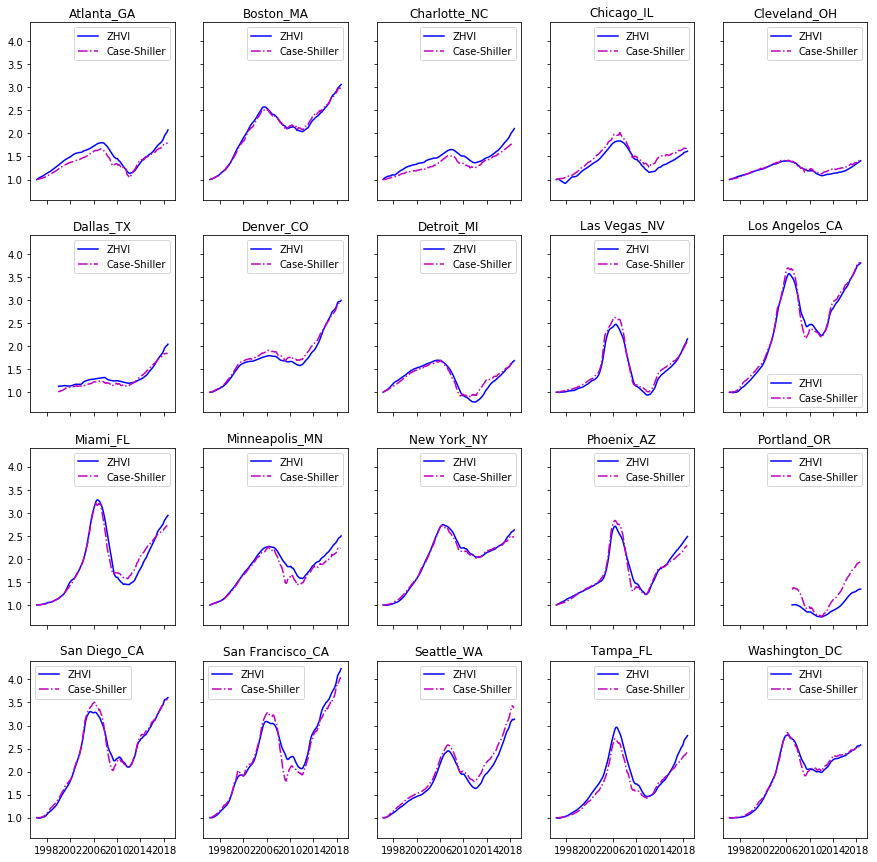

In [218]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15, 15), sharey=True, sharex=True) 
counter = 0
for row in ax:
    for col in row:
        start_dt = max(ZHVI_norm.iloc[:,counter].dropna().index[0], Case_Shiller_norm.iloc[:,counter].dropna().index[0])
        col.plot(ZHVI_norm.iloc[:,counter][start_dt:], label='ZHVI', color = 'b')
        col.plot(Case_Shiller_norm.iloc[:,counter][start_dt:], label='Case-Shiller', color = 'm', linestyle = '-.')
        col.set_title(Case_Shiller.columns[counter])
        col.legend()
        counter += 1

###  Note that the ZHVI Index methodology removes foreclosures from their estimates so their data should be inherently upward-biased relative to the Case-Schiller data. 

### The resulting multiplicative factors will allow you to translate statements about ZHVI to statements about Case-Schiller. 

### Use normailized series to calculate

In [174]:
multiplicative=[]
for i in range(len(Case_Shiller_norm.columns)):
    factor = Case_Shiller_norm[Case_Shiller_norm.columns[i]].dropna()/ZHVI_norm[ZHVI_norm.columns[i]].dropna()
    multiplicative.append(factor)

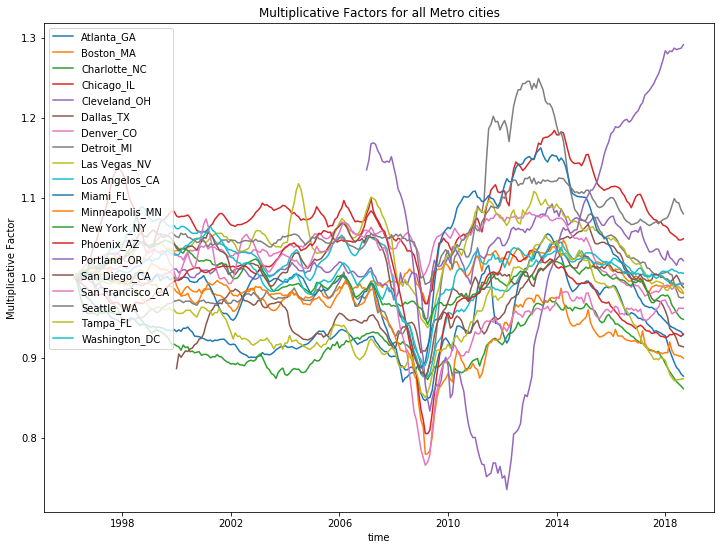

In [175]:
plt.figure(figsize = (12,9))
for i in range(len(multiplicative)):
    plt.plot(multiplicative[i], label=Case_Shiller.columns[i])
    plt.xlabel("time")
    plt.ylabel("Multiplicative Factor")
    plt.legend(loc='upper left')
plt.title("Multiplicative Factors for all Metro cities")
plt.show()

### ●	Let Spread = ConversionMultiplier – 1 for each metro area. What does the SpreadFactor tell you about foreclosures? Can you verify using the %foreclosure data in Zillow? Are there any other factors that contribute to Spread?

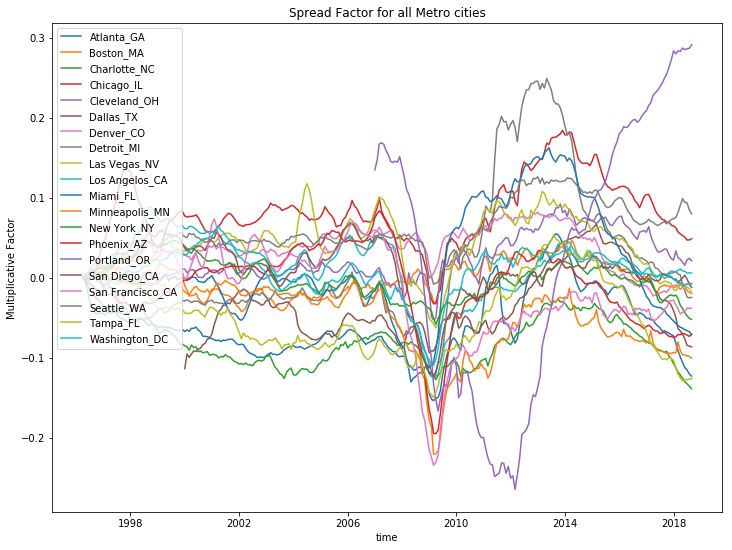

In [177]:
plt.figure(figsize = (12,9))
for i in range(len(multiplicative)):
    plt.plot(multiplicative[i]-1, label=Case_Shiller.columns[i])
    plt.xlabel("time")
    plt.ylabel("Multiplicative Factor")
    plt.legend(loc='upper left')
plt.title("Spread Factor for all Metro cities")
plt.show()

### ●	Can you predict the C-S index returns at time t from the ZHVI index returns ones at time t-1? How about the reverse? What is the accuracy of your predictions?

In [246]:
ZHVI_pct = 100.*ZHVI_norm.pct_change()[1:]
CS_pct = 100.*Case_Shiller_norm.pct_change()[1:]
ZHVI_pct

RegionName,"Atlanta, GA","Boston, MA","Charlotte, NC","Chicago, IL","Cleveland, OH","Dallas-Fort Worth, TX","Denver, CO","Detroit, MI","Las Vegas, NV","Los Angeles-Long Beach-Anaheim, CA","Miami-Fort Lauderdale, FL","Minneapolis-St Paul, MN","New York, NY","Phoenix, AZ","Portland, OR","San Diego, CA","San Francisco, CA","Seattle, WA","Tampa, FL","Washington, DC"
Date,,,,,,,,,,,,,,,,,,,,
1996-05-01,0.585366,0.333111,1.148225,0.433839,0.195503,0.086730,0.074683,0.638978,-0.078125,-0.117233,0.105263,0.188679,-0.121212,0.572519,NaN,-0.244499,-0.087566,-0.192678,-0.397878,-0.192555
1996-06-01,0.775946,0.398406,1.031992,0.287977,0.292683,0.086655,0.074627,0.740741,-0.156372,-0.176056,0.000000,0.376648,-0.121359,0.664137,NaN,-0.245098,-0.043821,-0.064350,-0.399467,-0.128617
1996-07-01,0.769971,0.396825,1.021450,0.071788,0.389105,0.173160,0.074571,0.630252,-0.156617,-0.176367,0.000000,0.469043,-0.182260,0.565504,NaN,-0.245700,0.000000,0.000000,-0.267380,-0.193175
1996-08-01,0.764088,0.395257,0.808898,-0.071736,0.290698,0.172861,0.149031,0.626305,0.000000,-0.176678,0.000000,0.466853,-0.121729,0.562324,NaN,-0.184729,0.043840,0.128783,-0.134048,-0.129032
1996-09-01,0.758294,0.393701,0.601805,-0.358938,0.289855,0.172563,0.223214,0.622407,0.000000,-0.117994,-0.105152,0.371747,-0.121877,0.559180,NaN,-0.061690,0.175285,0.257235,0.000000,-0.064599
1996-10-01,0.658514,0.326797,0.598205,-0.576369,0.385356,0.258398,0.296956,0.618557,0.078431,-0.059067,0.105263,0.462963,-0.061013,0.556070,NaN,0.061728,0.262467,0.320718,0.134228,0.000000
1996-11-01,0.560748,0.390879,0.396432,-0.724638,0.383877,0.171821,0.370096,0.614754,0.156740,0.000000,0.105152,0.276498,0.000000,0.460829,NaN,0.061690,0.436300,0.447570,0.134048,0.064641
1996-12-01,0.557621,0.454250,0.394867,-0.656934,0.382409,0.171527,0.516224,0.712831,0.234742,0.118203,0.210084,0.367647,0.122100,0.550459,NaN,0.308261,0.608167,0.509230,0.267738,0.193798
1997-01-01,0.554529,0.581395,0.589971,-0.587803,0.380952,0.171233,0.586941,0.808898,0.234192,0.295159,0.419287,0.366300,0.243902,0.547445,NaN,0.430240,0.734024,0.569981,0.400534,0.257898


In [247]:
#use 1996.5-2018.8 to predict 2018.9
CS_pred = []
CS_true = []
CS_fit = []
CS_true_fit = []
coef = []
variance = []
MSE = []
for i in range(len(CS_pct.columns)):
    start_dt = max(ZHVI_pct.iloc[:,i].dropna().index[0], CS_pct.iloc[:,i].dropna().index[0])
    df1 = ZHVI_pct.loc[start_dt:]
    df2 = CS_pct.loc[start_dt:]
    ols_train = df1.iloc[:-3,i]#96.5.1-18.7.1
    ols_test = df1.iloc[-3,i]#18.8.1-18.8.1
    ols_y_train = df2.iloc[1:-1,i]#96.6.1-18.8,1
    ols_y_test = df2.iloc[-1:,i]#18.9.1
    #normalize
    #ols_train = preprocessing.scale(ols_train)
    #ols_test = preprocessing.scale(ols_test)
    #ols_y_train = preprocessing.scale(ols_y_train)
    #ols_y_test = preprocessing.scale(ols_y_test)
    CS_true.append(ols_y_test[0])
    regr = linear_model.LinearRegression()

    ## Train the model using the training sets
    regr.fit(np.array(ols_train).reshape(-1,1), ols_y_train)

    # # Make predictions using the testing set
    ols_pred = regr.predict(np.array(ols_test).reshape(-1,1))
    ols_pred_train = regr.predict(np.array(ols_train).reshape(-1,1))
    CS_pred.append(ols_pred)
    CS_fit.append(ols_pred_train)
    CS_true_fit.append(ols_y_train)
    coef.append(regr.coef_[0])
    variance.append(explained_variance_score(ols_y_test, ols_pred))
    MSE.append(mean_squared_error(ols_y_test, ols_pred))
    print('For ' + CS_pct.columns[i] + ': \n')
    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % mean_squared_error(ols_y_test, ols_pred))
    # Explained variance score: 1 is perfect prediction
    print('Explained Variance score: %.2f \n' % explained_variance_score(ols_y_test, ols_pred))

For Atlanta_GA: 

Coefficients: 
 [0.79028818]
Mean squared error: 0.04
Explained Variance score: 1.00 

For Boston_MA: 

Coefficients: 
 [0.85632042]
Mean squared error: 0.01
Explained Variance score: 1.00 

For Charlotte_NC: 

Coefficients: 
 [0.64230842]
Mean squared error: 0.00
Explained Variance score: 1.00 

For Chicago_IL: 

Coefficients: 
 [0.69653207]
Mean squared error: 0.06
Explained Variance score: 1.00 

For Cleveland_OH: 

Coefficients: 
 [0.68758833]
Mean squared error: 0.00
Explained Variance score: 1.00 

For Dallas_TX: 

Coefficients: 
 [0.47899167]
Mean squared error: 0.02
Explained Variance score: 1.00 

For Denver_CO: 

Coefficients: 
 [0.82907486]
Mean squared error: 0.03
Explained Variance score: 1.00 

For Detroit_MI: 

Coefficients: 
 [0.70561745]
Mean squared error: 0.03
Explained Variance score: 1.00 

For Las Vegas_NV: 

Coefficients: 
 [0.97987166]
Mean squared error: 0.24
Explained Variance score: 1.00 

For Los Angelos_CA: 

Coefficients: 
 [1.08642742]
M

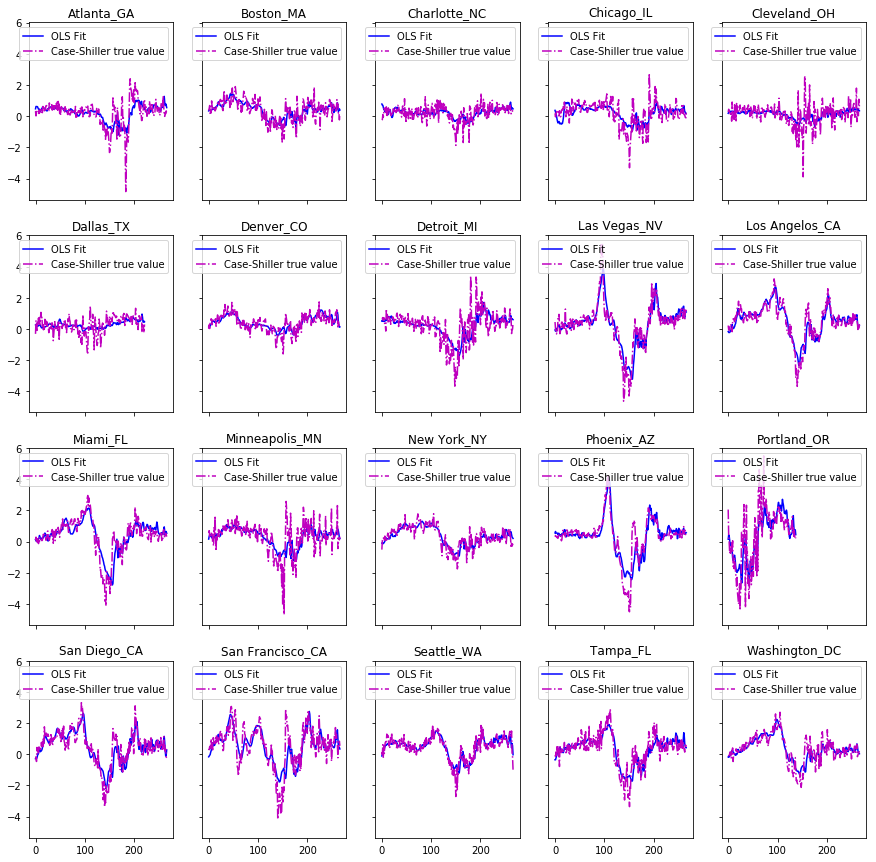

In [236]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15, 15), sharey=True, sharex=True) 
counter = 0
for row in ax:
    for col in row:
        col.plot(np.arange(len(CS_fit[counter])), CS_fit[counter], label='OLS Fit', color = 'b')
        col.plot(np.arange(len(CS_true_fit[counter])), CS_true_fit[counter], label='Case-Shiller true value', color = 'm', linestyle = '-.')
        col.set_title(CS_pct.columns[counter])
        col.legend()
        counter += 1

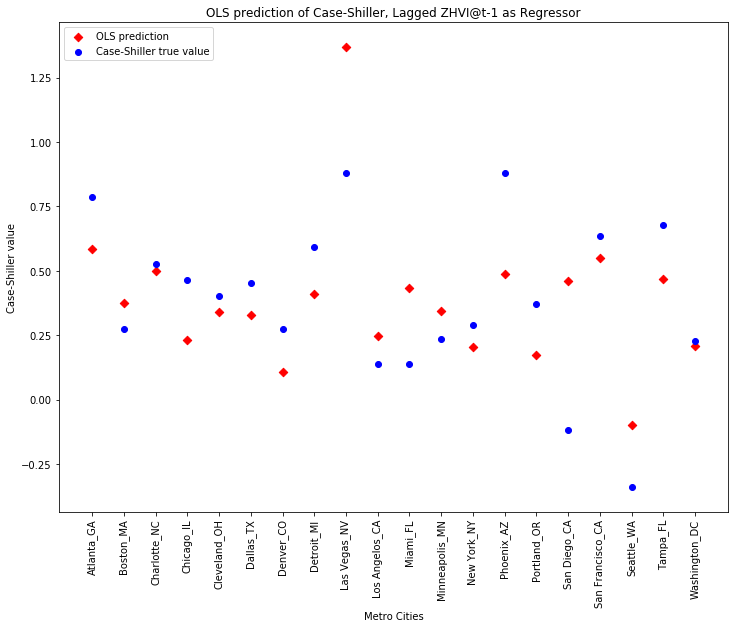

In [266]:
plt.figure(figsize = (12,9))
plt.scatter(CS_pct.columns, CS_pred, c="red", marker = 'D', label="OLS prediction")
plt.scatter(CS_pct.columns, CS_true, color="blue", label="Case-Shiller true value", linewidth=1)
plt.xlabel("Metro Cities")
plt.ylabel("Case-Shiller value")
plt.title("OLS prediction of Case-Shiller, Lagged ZHVI@t-1 as Regressor")
plt.xticks(rotation=90)
plt.legend(loc='upper left')
plt.show()

In [248]:
df = pd.DataFrame({'Coefficient': coef, 'Accuracy': MSE})
df.set_index(CS_pct.columns).T

RegionName,Atlanta_GA,Boston_MA,Charlotte_NC,Chicago_IL,Cleveland_OH,Dallas_TX,Denver_CO,Detroit_MI,Las Vegas_NV,Los Angelos_CA,Miami_FL,Minneapolis_MN,New York_NY,Phoenix_AZ,Portland_OR,San Diego_CA,San Francisco_CA,Seattle_WA,Tampa_FL,Washington_DC
Coefficient,0.790288,0.856320,0.642308,0.696532,0.687588,0.478992,0.829075,0.705617,0.979872,1.086427,0.819809,0.945578,0.904851,1.033459,1.614924,1.048381,1.103417,0.911272,0.877357,0.955982
Accuracy,0.040048,0.010037,0.000732,0.055628,0.003525,0.015037,0.027876,0.032998,0.240130,0.011922,0.086762,0.012264,0.006979,0.154554,0.039684,0.333673,0.007106,0.057231,0.043640,0.000388


### The reverse

In [255]:
#use 1996.5-2018.8 to predict 2018.9
ZHVI_pred = []
ZHVI_true = []
ZHVI_fit = []
ZHVI_true_fit = []
coef = []
variance = []
MSE = []
for i in range(len(ZHVI_pct.columns)):
    start_dt = max(ZHVI_pct.iloc[:,i].dropna().index[0], CS_pct.iloc[:,i].dropna().index[0])
    df1 = CS_pct.loc[start_dt:]
    df2 = ZHVI_pct.loc[start_dt:]
    ols_train = df1.iloc[:-1,i]#96.5.1-18.8.1
    ols_test = df1.iloc[-1,i]#18.9.1
    ols_y_train = df2.iloc[1:-1,i]#96.6.1-18.9.1
    ols_y_test = df2.iloc[-1:,i]#18.10.1
    #normalize
    #ols_train = preprocessing.scale(ols_train)
    #ols_test = preprocessing.scale(ols_test)
    #ols_y_train = preprocessing.scale(ols_y_train)
    #ols_y_test = preprocessing.scale(ols_y_test)
    ZHVI_true.append(ols_y_test[0])
    regr = linear_model.LinearRegression()

    ## Train the model using the training sets
    regr.fit(np.array(ols_train).reshape(-1,1), ols_y_train)

    # # Make predictions using the testing set
    ols_pred = regr.predict(np.array(ols_test).reshape(-1,1))
    ols_pred_train = regr.predict(np.array(ols_train).reshape(-1,1))
    ZHVI_pred.append(ols_pred)
    ZHVI_fit.append(ols_pred_train)
    ZHVI_true_fit.append(ols_y_train)
    coef.append(regr.coef_[0])
    variance.append(explained_variance_score(ols_y_test, ols_pred))
    MSE.append(mean_squared_error(ols_y_test, ols_pred))
    print('For ' + ZHVI_pct.columns[i] + ': \n')
    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % mean_squared_error(ols_y_test, ols_pred))
    # Explained variance score: 1 is perfect prediction
    print('Explained Variance score: %.2f \n' % explained_variance_score(ols_y_test, ols_pred))

For Atlanta, GA: 

Coefficients: 
 [0.53803976]
Mean squared error: 0.32
Explained Variance score: 1.00 

For Boston, MA: 

Coefficients: 
 [0.6587341]
Mean squared error: 0.00
Explained Variance score: 1.00 

For Charlotte, NC: 

Coefficients: 
 [0.46714683]
Mean squared error: 0.19
Explained Variance score: 1.00 

For Chicago, IL: 

Coefficients: 
 [0.5578372]
Mean squared error: 0.00
Explained Variance score: 1.00 

For Cleveland, OH: 

Coefficients: 
 [0.21242784]
Mean squared error: 0.20
Explained Variance score: 1.00 

For Dallas-Fort Worth, TX: 

Coefficients: 
 [0.34067807]
Mean squared error: 0.16
Explained Variance score: 1.00 

For Denver, CO: 

Coefficients: 
 [0.70277565]
Mean squared error: 0.03
Explained Variance score: 1.00 

For Detroit, MI: 

Coefficients: 
 [0.61172686]
Mean squared error: 0.00
Explained Variance score: 1.00 

For Las Vegas, NV: 

Coefficients: 
 [0.84058907]
Mean squared error: 0.02
Explained Variance score: 1.00 

For Los Angeles-Long Beach-Anaheim

In [256]:
df = pd.DataFrame({'Coefficient': coef, 'Accuracy': MSE})
df.set_index(ZHVI_pct.columns).T

RegionName,"Atlanta, GA","Boston, MA","Charlotte, NC","Chicago, IL","Cleveland, OH","Dallas-Fort Worth, TX","Denver, CO","Detroit, MI","Las Vegas, NV","Los Angeles-Long Beach-Anaheim, CA","Miami-Fort Lauderdale, FL","Minneapolis-St Paul, MN","New York, NY","Phoenix, AZ","Portland, OR","San Diego, CA","San Francisco, CA","Seattle, WA","Tampa, FL","Washington, DC"
Coefficient,0.538040,0.658734,0.467147,0.557837,0.212428,0.340678,0.702776,0.611727,0.840589,0.743806,0.907056,0.426322,0.802364,0.755035,0.390501,0.726158,0.551727,0.817321,0.824162,0.741389
Accuracy,0.322991,0.000479,0.188737,0.000178,0.200402,0.163689,0.025469,0.004291,0.024703,0.000181,0.057891,0.033055,0.014426,0.022625,0.002184,0.018743,0.002475,0.327201,0.008834,0.003946


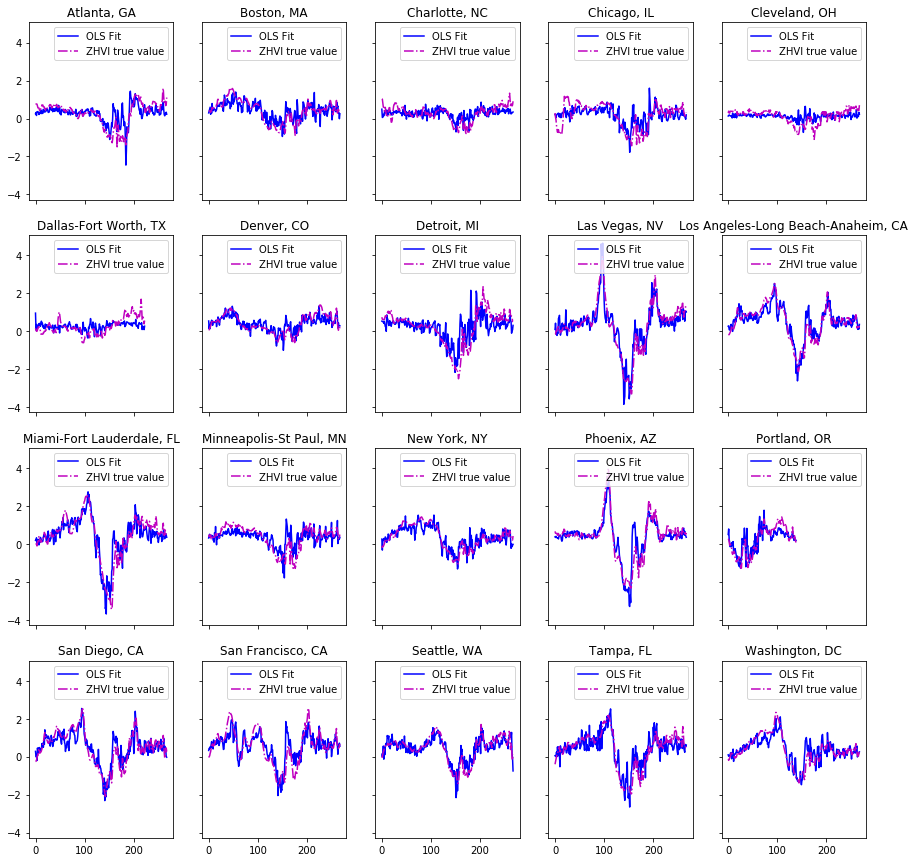

In [258]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15, 15), sharey=True, sharex=True) 
counter = 0
for row in ax:
    for col in row:
        col.plot(np.arange(len(ZHVI_fit[counter])), ZHVI_fit[counter], label='OLS Fit', color = 'b')
        col.plot(np.arange(len(ZHVI_true_fit[counter])), ZHVI_true_fit[counter], label='ZHVI true value', color = 'm', linestyle = '-.')
        col.set_title(ZHVI_pct.columns[counter])
        col.legend()
        counter += 1

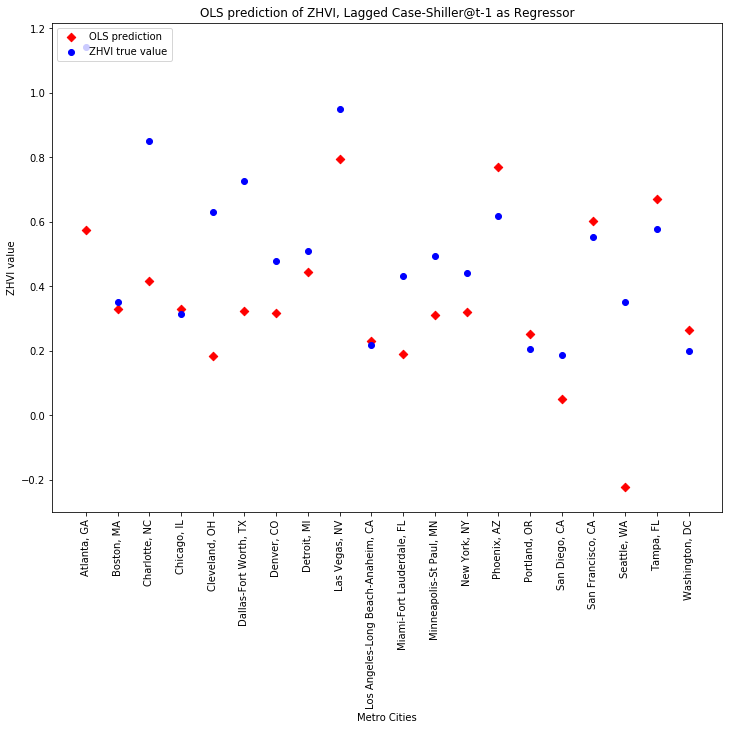

In [265]:
plt.figure(figsize = (12,9))
plt.scatter(ZHVI_pct.columns, ZHVI_pred, c="red", marker = 'D', label="OLS prediction")
plt.scatter(ZHVI_pct.columns, ZHVI_true, color="blue", label="ZHVI true value", linewidth=1)
plt.xlabel("Metro Cities")
plt.ylabel("ZHVI value")
plt.title("OLS prediction of ZHVI, Lagged Case-Shiller@t-1 as Regressor")
plt.xticks(rotation=90)
plt.legend(loc='upper left')
plt.show()